## 필수과제1
- 모델을 단순하게 RandomForest만 학습
- 타이타닉 데이터를 RF모델을 튜닝하여 과적합을 최소화 하여 하이퍼 파라미터를 찾고, 해당 하이퍼파라미터를 가지고 다시 한 번 샤플리를 진행해서
- 기존 베이스 모델의 샤플리값과 과적합을 최소화한 모델의 하이퍼파라미터로 샤플리값을 추출하는 것
- 둘을 비교해 주시면 됩니다.
    - **필수적으로**
    - 과적합을 최소화했다는 기준
        - 성능?
        - 그리드 서치 등을 통해 찾은 것인지?
        - 시각화 등으로도 보여주면서 과적합을 최소화 했다는 것을 코드와 함께 설명해 주셔야 합니다.

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import shap
from feature_engine.selection import DropCorrelatedFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
df = sns.load_dataset('titanic')

#데이터 전처리

df = df.dropna(subset=['age','embarked','deck'])
df['sex'] =df['sex'].map({'male':0,'female':1})
df['embarked'] =df['embarked'].astype('category').cat.codes
df['deck'] = df['deck'].astype('category').cat.codes

#필요한 피처만 추출

X = df[['pclass','sex','age','sibsp','parch','fare','embarked','deck']]
y = df['survived']

In [3]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=111)

In [4]:
# Baseline Random Forest Model
base_rf = RandomForestClassifier(random_state=111)
base_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=111)

In [5]:
# 성능 평가
y_pred_base = base_rf.predict(X_test)
print("Baseline Accuracy:", accuracy_score(y_test, y_pred_base))
print("Baseline F1 Score:", f1_score(y_test, y_pred_base, average='binary'))

Baseline Accuracy: 0.7090909090909091
Baseline F1 Score: 0.7714285714285715


In [6]:
# BorutaPy 불러오기
base_boruta_selector = BorutaPy(base_rf, n_estimators = 'auto', random_state=111)
base_boruta_selector.fit(X.values, y.values) #행렬로 대입해서

BorutaPy(estimator=RandomForestClassifier(n_estimators=40,
                                          random_state=RandomState(MT19937) at 0x7FDF5D1B6C40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FDF5D1B6C40)

In [7]:
print('선택된 특성',X.columns[base_boruta_selector.support_].tolist())

선택된 특성 ['sex', 'age', 'fare']


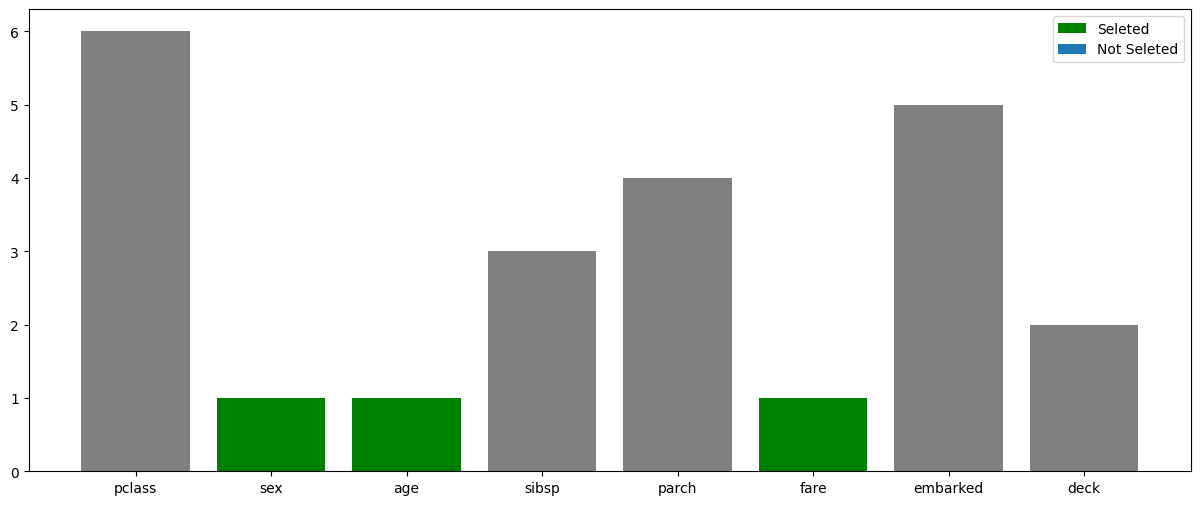

In [8]:
import matplotlib.pyplot as plt

green_area = X.columns[base_boruta_selector.support_].tolist()
blue_area = X.columns[base_boruta_selector.support_weak_].tolist()

# 중요도 랭킹으로 확인하기
feature_importance = base_boruta_selector.ranking_

# 시각화로 살펴보기

plt.figure(figsize=(15,6))
plt.bar(X.columns, feature_importance,color= 'grey')
plt.bar(green_area, [1]*len(green_area), color='green', label='Seleted')
plt.bar(blue_area, [2]*len(blue_area), color='blue', label='Not Seleted')
plt.legend()

In [10]:
# SHAP 값 계산
explainer_base = shap.TreeExplainer(base_rf)
shap_values_base = explainer_base.shap_values(X_test)

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. Consider retrying with the feature_perturbation='interventional' option. This check failed because for one of the samples the sum of the SHAP values was 0.651628, while the model output was 0.375000. If this difference is acceptable you can set check_additivity=False to disable this check.

In [ ]:
# SHAP 요약 플롯 (Baseline)
shap.summary_plot(shap_values_base, X_test, plot_type='bar', show=False)
plt.title("Baseline Model SHAP Values")
plt.show()